In [1]:
%pip install semantic-link==0.11.1 semantic-link-labs==0.11.2  > /dev/null 2>&1
import pandas as pd
import requests 
import json
import base64
import sempy_labs as labs
import sempy_labs.report as rep 
import sempy.fabric as semfabric
from urllib.parse import urlparse, unquote
from typing import Union, Optional


Note: you may need to restart the kernel to use updated packages.


In [2]:
## You can change these as you like
lakehouse_name = 'Baraa_LH'
warehouse_name = 'Baraa_WH'
semantic_model_name = 'Baraa_SMM'
report_name = 'Baraa_Report'
gold_notebook_name = 'gold_layer_processing_notebook'
silver_notebook_name = 'silver_layer_processing_notebook'
timezone = "Africa/Lagos" # this is used for adding Data warehouse creation dates column in the transformation notebooks

## Don't Change these ⚠️⚠️⚠️⚠️⚠️⚠️⚠️
crm_data_relative_path = "datasets/source_crm"
erp_data_relative_path = "datasets/source_erp"

workspace_name=notebookutils.runtime.context['currentWorkspaceName']
workspace_id = notebookutils.runtime.context['currentWorkspaceId']

create_semantic_model_uri = f"v1/workspaces/{workspace_id}/semanticModels"
semantic_model_github_url = "https://github.com/maleek004/baraaE2E/tree/main/Baraa_DL_SMM.SemanticModel"
semantic_model_parts = ''
semantic_model_request_body= ''
semantic_model_id = ''

create_report_uri = f"v1/workspaces/{workspace_id}/reports"
report_github_folder = 'https://github.com/maleek004/baraaE2E/tree/main/Baraa_DL_Report.Report'
report_parts = ''
create_report_request_body = ''
report_id =''

silver_notebook_url = 'https://raw.githubusercontent.com/maleek004/auto-fabric-setup-baraa/refs/heads/main/Create_silver_layer_Notebook.ipynb'
gold_notebook_url= 'https://raw.githubusercontent.com/maleek004/auto-fabric-setup-baraa/refs/heads/main/Load_gold_layer.ipynb'

crm_dataset_urls = {"cust_info.csv":"https://raw.githubusercontent.com/DataWithBaraa/sql-data-warehouse-project/refs/heads/main/datasets/source_crm/cust_info.csv"
                    ,"prd_info.csv":"https://raw.githubusercontent.com/DataWithBaraa/sql-data-warehouse-project/refs/heads/main/datasets/source_crm/prd_info.csv"
                    ,"sales_details.csv":"https://raw.githubusercontent.com/DataWithBaraa/sql-data-warehouse-project/refs/heads/main/datasets/source_crm/sales_details.csv"}

erp_dataset_urls = {"CUST_AZ12.csv":"https://raw.githubusercontent.com/DataWithBaraa/sql-data-warehouse-project/refs/heads/main/datasets/source_erp/CUST_AZ12.csv"
                    ,"LOC_A101.csv":"https://raw.githubusercontent.com/DataWithBaraa/sql-data-warehouse-project/refs/heads/main/datasets/source_erp/LOC_A101.csv"
                    ,"PX_CAT_G1V2.csv":"https://raw.githubusercontent.com/DataWithBaraa/sql-data-warehouse-project/refs/heads/main/datasets/source_erp/PX_CAT_G1V2.csv"}

## Functions

In [3]:
####################### FOR SENDING POST REQUESTS TO FABRIC REST API (WITHOUT BEARER TOKEN)
def fabriclient_post(url, request_body):

    client = semfabric.FabricRestClient()
    
    response = client.request(method = "POST", path_or_url=url, lro_wait=True, json = request_body)
    print(response.status_code)
    print(response.text)
    response.raise_for_status()
    
    response_json = response.json()
    return response_json.get('id')

####################### THIS FUNCTION EXTRACTS THE DEFINITION PART OF AN ITEM SYNCED TO GITHUB AND RETURNS THE FULL LIST WITH BASE64 PAYLOAD

def get_definition_parts_from_github(github_folder_url, isReport=False, report_pbir_definition: Optional[Union[dict, str, bytes]] = None):
    """
    Given a GitHub folder URL, recursively retrieves all files under it
    and returns a 'parts' list formatted like:
    [
        {
            "path": "definition.pbism",
            "payload": "<base64 string>",
            "payloadType": "InlineBase64"
        },
        ...
    ]

    Parameters:
    ----------
    github_folder_url : str
        The GitHub folder URL to process.
    isReport : bool, optional
        Set to True if the folder represents a Power BI report.
        If True, `report_pbir_definition` must be provided.
    report_pbir_definition : bytes, optional
        The customized definition.pbir file to use (required if isReport=True).

    Raises:
    -------
    ValueError
        If isReport=True but report_pbir_definition is not provided.
    """

    # ---  Validate parameters ---
    if isReport and report_pbir_definition is None:
        raise ValueError(
            "Since you are trying to build a report, you must provide a custom 'definition.pbir' "
            "file that includes a 'byConnection' dataReference and the target 'semanticmodelid'.\n"
            "For more information, visit: "
            "https://learn.microsoft.com/en-us/power-bi/developer/projects/projects-report"
            "?tabs=v2%2Cdesktop#definitionpbir"
        )
    # --- Helper: Parse the folder URL ---
    def parse_github_folder_url(url: str):
        parsed = urlparse(url)
        path_parts = parsed.path.strip("/").split("/")

        if len(path_parts) < 2:
            raise ValueError("Invalid GitHub URL format.")

        owner = path_parts[0]
        repo = path_parts[1]

        # Handle 'tree/main/...'
        if len(path_parts) > 3 and path_parts[2] in ("tree", "blob"):
            subpath = "/".join(path_parts[4:])
        else:
            subpath = "/".join(path_parts[2:])

        return owner, repo, unquote(subpath)

    # --- Helper: Recursively fetch all files and relative paths ---
    def get_all_files_with_relative_paths(owner: str, repo: str, base_path: str, current_path: str = None):
        if current_path is None:
            current_path = base_path

        api_url = f"https://api.github.com/repos/{owner}/{repo}/contents/{current_path}"
        response = requests.get(api_url)
        response.raise_for_status()
        items = response.json()

        files = []
        for item in items:
            if item["type"] == "file":
                relative_path = item["path"].replace(base_path + "/", "")
                files.append({
                    "raw_url": item["download_url"],
                    "relative_path": relative_path
                })
            elif item["type"] == "dir":
                files.extend(get_all_files_with_relative_paths(owner, repo, base_path, item["path"]))
        return files

    # --- Helper: Download and encode file content to Base64 ---
    def download_and_encode_base64(url: str) -> str:
        response = requests.get(url)
        response.raise_for_status()
        file_content = response.content  # .content was the safest option
        return base64.b64encode(file_content).decode("utf-8")

    # --- Main flow ---
    owner, repo, subpath = parse_github_folder_url(github_folder_url)
    files = get_all_files_with_relative_paths(owner, repo, subpath)

    parts = []
    for file in files:
        if isReport and file['relative_path'] == 'definition.pbir':
            # Safely handle dicts, strings, or bytes
            if isinstance(report_pbir_definition, dict):
                report_pbir_definition_bytes = json.dumps(report_pbir_definition, indent=2).encode("utf-8")
            elif isinstance(report_pbir_definition, str):
                report_pbir_definition_bytes = report_pbir_definition.encode("utf-8")
            else:
                report_pbir_definition_bytes = report_pbir_definition  # assume bytes
            encoded = base64.b64encode(report_pbir_definition_bytes).decode("utf-8")
        else:
            encoded = download_and_encode_base64(file["raw_url"])
        parts.append({
            "path": file["relative_path"],
            "payload": encoded,
            "payloadType": "InlineBase64"
        })

    print(f"✅ Retrieved {len(parts)} files from {repo}/{subpath}")
    return parts

##################### THIS FUNCTION DOWNLOADS DATASET TO LAKEHOUSE
def download_datasets(dataset_urls, save_dir="."):
    for filename, url in dataset_urls.items():
        print(f"Downloading {filename}...")
        try:
            response = requests.get(url, timeout=15)
            response.raise_for_status()  # Raise exception for HTTP errors
            with open(f"{save_dir}/{filename}", "wb") as f:
                f.write(response.content)
            print(f"✅ {filename} downloaded successfully.")
        except requests.exceptions.RequestException as e:
            print(f"❌ Failed to download {filename}: {e}")

################# Check if an item exists
def item_exists(item_name, item_type) -> bool:

    items_df = semfabric.list_items(item_type)

    if item_name in items_df['Display Name'].values:
        print(f'{item_name} of type {item_type} exists')
        return True
    else:
        print(f'{item_name} of type {item_type} does not exist')
        return False   

################ download notebook from github and optionally attach it to a lakehouse
def import_notebook(notebook_import_name, githuburl, update_lakehouse=False , workspace_id=None, lakehouse_name=None ) -> str:
    if item_exists(notebook_import_name, "Notebook"):
        print('notebook already exists skipping download')
    else:
        # import notebook and return notebook_id
        result = labs.import_notebook_from_web( notebook_name=notebook_import_name, url=githuburl)
            
        # update the default lakehouse (only if allowed)
        if update_lakehouse:
            if not workspace_id or not lakehouse_name:
                raise ValueError("workspace_id and lakehouse_name must be provided when update_lakehouse=True")
            notebookutils.notebook.updateDefinition(
                name=notebook_import_name, 
                workspaceId=workspace_id, 
                defaultLakehouse=lakehouse_name, 
                defaultLakehouseWorkspace=workspace_id
            )
        
    # Return notebook id
    notebook_id = semfabric.resolve_item_id(item_name=notebook_import_name, type="Notebook")

    print(f"notebookname: {notebook_import_name}, notebook_id: {notebook_id}")

    return notebook_id

##########


## Create Lakehouse
#### Created directories in the lakehouse
#### Mounted the file directory of the lakehouse so that we can write files to it directly
#### Downloaded files from Github into folders in the Lakehouse  

In [4]:
# creating a new lakehouse where our data will be downladed will be downloaded into and will alsoe be used as the siver layer
if item_exists(lakehouse_name , 'Lakehouse'):
    print('lakehouse already exists, getting the lakehouse id')
    lakehouse_id=notebookutils.lakehouse.get(lakehouse_name, workspace_id)['id']
    abfs_path =f'abfss://{workspace_id}@onelake.dfs.fabric.microsoft.com/{lakehouse_id}'
else:
    lakehouse = notebookutils.lakehouse.create(lakehouse_name)    
    lakehouse_id = lakehouse['id']
    abfs_path = lakehouse.get('properties',{}).get('abfsPath')
abfs_path

Baraa_LH of type Lakehouse exists
lakehouse already exists, getting the lakehouse id


'abfss://a8090863-3315-4b19-9138-b7069c51339a@onelake.dfs.fabric.microsoft.com/ce8d3b4b-b9b1-4fc3-9434-a6c833364cdf'

In [5]:
# creating directories in our destination lakehouse (that this notebook is not attached to, hence the use of abfs_path) 
notebookutils.fs.mkdirs(f'{abfs_path}/Files/{crm_data_relative_path}')
notebookutils.fs.mkdirs(f'{abfs_path}/Files/{erp_data_relative_path}')

True

In [6]:
##  mount the Files section of the new lakehouse 
files_directory = abfs_path + '/Files'
mount_point = "/mnt/lakehouse/" + lakehouse_name + "/Files"
notebookutils.fs.mount(files_directory, mount_point)
base_dir_local_path = notebookutils.fs.getMountPath(mount_point)
base_dir_local_path

'/synfs/notebook/0ac26bdf-ec5d-46f2-a7f1-cdffcdbac911/mnt/lakehouse/Baraa_LH/Files'

In [7]:
crm_data_full_local_path = f'{base_dir_local_path}/{crm_data_relative_path}'
erp_data_full_local_path = f'{base_dir_local_path}/{erp_data_relative_path}'


In [8]:
download_datasets(crm_dataset_urls, crm_data_full_local_path)
download_datasets(erp_dataset_urls, erp_data_full_local_path)


✅ cust_info.csv downloaded successfully.
✅ prd_info.csv downloaded successfully.


✅ sales_details.csv downloaded successfully.


✅ CUST_AZ12.csv downloaded successfully.
✅ LOC_A101.csv downloaded successfully.
✅ PX_CAT_G1V2.csv downloaded successfully.


## Create Warehouse

In [9]:
#Creating a warehouse where our gold layer views and tables will be stored

if item_exists(warehouse_name , 'Warehouse'):
    print('warehouse already exists, getting the warehouse_id')
    df = semfabric.list_items('Warehouse')
    warehouse_id = df.loc[df['Display Name'] == warehouse_name, 'Id'].iloc[0]
else:
    url = f"https://api.fabric.microsoft.com/v1/workspaces/{workspace_id}/warehouses"
    request_body = {"displayName": warehouse_name}
    warehouse_id = fabriclient_post(url,request_body)
warehouse_id

Baraa_WH of type Warehouse exists
warehouse already exists, getting the warehouse_id


'4bd1c881-36fd-45b0-b8a3-baec8741a9ef'

## Download and run transformation notebooks 

In [10]:
#import notebooks and get Notebook Ids for the 2 notebooks to be used in subsequent steps
silver_layer_notebook_id = import_notebook(notebook_import_name=silver_notebook_name, githuburl=silver_notebook_url, update_lakehouse=True, workspace_id=workspace_id, lakehouse_name = lakehouse_name)
gold_layer_notebook_id = import_notebook(gold_notebook_name,gold_notebook_url)

silver_layer_processing_notebook of type Notebook exists
notebook already exists skipping download
notebookname: silver_layer_processing_notebook, notebook_id: 48843d25-b416-48ac-97e5-23d45d4cc631
gold_layer_processing_notebook of type Notebook exists
notebook already exists skipping download
notebookname: gold_layer_processing_notebook, notebook_id: 4ee5720c-83f0-4145-bcec-f2bdecb6a67e


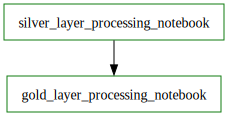

{'silver_layer_processing_notebook': {'exitVal': 'DONE 👍🏽👍🏽',
  'exception': None,
  'runId': '36959b32-2dca-4d5a-91c5-7cb763d1b638'},
 'gold_layer_processing_notebook': {'exitVal': 'DONE 👍🏽👍🏽',
  'exception': None,
  'runId': 'e24ff9dd-6d84-4608-adc8-dcba88b9901f'}}

In [12]:
DAG = {
    "activities": [
        {
            "name": silver_notebook_name, 
            "path": silver_notebook_name, 
            "timeoutPerCellInSeconds": 90,
            "args": {"useRootDefaultLakehouse": True, "abfs_path":abfs_path, "workspaceId": workspace_id , "lakehouseId": lakehouse_id , "timezone" : timezone}
        },
        {
            "name": gold_notebook_name,
            "path": gold_notebook_name,
            "timeoutPerCellInSeconds": 90,
            "args":{"lakehouse_name": lakehouse_name , "warehouse_name":warehouse_name},
            "retry": 2, ### because it takes a while for the SQL endpoint of the lakehouse to refresh, and we will be depending on it so the first try might fail...
            "retryIntervalInSeconds": 50,
            "dependencies": [silver_notebook_name]
        }
    ],
    "timeoutInSeconds": 480, # max 4 mins for the entire pipeline
}

notebookutils.notebook.runMultiple(DAG, {"displayDAGViaGraphviz":True})

### Create semantic model from Fabric REST API and attach it to warehouse


In [13]:
if item_exists(semantic_model_name, 'SemanticModel'):
        print('semantic model already exists, getting the ID ')
        df = semfabric.list_items('SemanticModel')
        semantic_model_id = df.loc[df['Display Name'] == semantic_model_name, 'Id'].iloc[0]

else:
        semantic_model_parts = get_definition_parts_from_github(semantic_model_github_url)
        semantic_model_request_body= {
                                "displayName": semantic_model_name,
                                "description": "semantic model for E2E demo",
                                "definition":{
                                        "parts": semantic_model_parts
                                } 
                            }

        semantic_model_id = fabriclient_post(create_semantic_model_uri, semantic_model_request_body)

Baraa_SMM of type SemanticModel exists
semantic model already exists, getting the ID 


In [14]:
labs.directlake.update_direct_lake_model_connection(dataset = semantic_model_name,source= warehouse_name, source_type="Warehouse")

🟢 The expression in the 'Baraa_SMM' semantic model within the 'test10k' workspace has been updated to point to the 'Baraa_WH' warehouse in the 'test10k' workspace.


## Create report 

In [15]:
if item_exists(report_name, 'Report'):
        print('Report already exists, getting the ID ')
        df = semfabric.list_items('Report')
        report_id = df.loc[df['Display Name'] == report_name, 'Id'].iloc[0]
else:
    custom_pbir = {
        "$schema": "https://developer.microsoft.com/json-schemas/fabric/item/report/definitionProperties/2.0.0/schema.json",
        "version": "4.0",
        "datasetReference": {
            "byConnection": {
                "connectionString": f"semanticmodelid={semantic_model_id}"
            }
        }
    }

    report_parts = get_definition_parts_from_github(report_github_folder, isReport=True , report_pbir_definition=custom_pbir)
    create_report_request_body = {
            "displayName": report_name,
            "description": "report created using Fabric REST API",
            "definition" : {
                "parts": report_parts
                }
            }
    report_id = fabriclient_post(create_report_uri, create_report_request_body)

Baraa_Report of type Report exists
Report already exists, getting the ID 
